# Chapter 4 训练模型

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. 线性回归（Linear Regression）

**线性回归模型预测**：

$$ \hat{y}=\theta_0+\theta_1 x_1+\theta_2 x_2+\cdots+\theta_n x_n $$

方程中：
1. $\hat{y}$ 表示预测值
2. $n$ 是特征数量
3. $x_i$ 是第 $i$ 个特征值
4. $\theta_j$ 是第 $j$ 个模型参数，包括偏差项 $\theta_0$ ，特征权重 $\theta_1,\theta_2,\cdots,\theta_n$ 

**写成向量形式**：

$$ \hat{y}=h_{\pmb{\theta}}(\pmb{x})=\pmb{\theta}\cdot\pmb{x} $$

方程中：

1. $h_{\pmb{\theta}}$ 是使用模型参数 $\pmb{\theta}$ 的假设函数
2. $\pmb{\theta}$ 是模型参数向量，包括偏差项 $\theta_0$ 和特征权重 $\theta_1$ 到 $\theta_n$ 
3. $\pmb{x}$ 是实例特征向量，包括 $x_0$ 到 $x_1$ ，其中 $x_0$ 总是为1
4. $\pmb{\theta}\cdot\pmb{x}$ 是向量 $\pmb{\theta}$ 与 $\pmb{x}$ 的点积，等价于 $\theta_0 x_0+\theta_1 x_1+\theta_2 x_2+\cdots+\theta_n x_n$

**注意**：在机器学习中，向量通常被表示为**列变量**，它是只有一列的二维数组。如果 $\pmb{\theta}$ 和 $\pmb{x}$ 是列向量，那么预测是 $\hat{y}=\pmb{\theta}^T\pmb{x}$ 。在这本书中，将使用该符号来避免在点积和矩阵乘法之间切换。

好吧，这是线性回归模型，但是我们如何训练它呢？回想一下，训练一个模型意味着设置它的参数，使模型最拟合训练集。为此，我们首先需要测量模型与训练数据的拟合程度。在第二章中，我们看到一个回归模型最常见的性能度量是均方根误差。因此，为了训练一个线性回归模型，我们需要找到使 $RMSE$ 最小化的 $\theta$ 值。在实践中，最小化均方误差（$MSE$）比 $RMSE$ 更简单，而且它会得到相同的结果（因为最小化正函数的值也最小化其平方根）。

**注意**：学习算法通常会在训练期间优化损失函数，与用于评估最终模型的性能度量不同。这通常是因为该函数更容易优化和/或因为它具有仅在训练期间需要的额外项（例如，用于正则化）。一个好的性能指标尽可能接近最终的业务目标。良好的训练损失易于优化并且与指标密切相关。例如，分类器通常使用诸如对数损失之类的成本函数进行训练（正如您将在本章后面看到的那样），但使用精度/召回率进行评估。对数损失很容易最小化，这样做通常会提高精度/召回率。

**线性回归的MSE**：

$$ MSE(\pmb{X},h_{\pmb{\theta}})=\frac{1}{m}\sum_{i=1}^m(\pmb{\theta}^T\pmb{x}^{(i)}-y^{(i)})^2 $$

### 1.1 标准方程（The Normal Equation）

为了找到使 $MSE$ 最小化的 $\pmb{\theta}$ 值，存在一个封闭形式的解——换句话说，是一个直接给出结果的数学方程。这被称为**标准方程**。

**标准方程**：

$$ \hat{\pmb{\theta}} = (\pmb{X}^T\pmb{X})^{-1}\pmb{X}^T\pmb{y} $$

方程中：

1. $\hat{\pmb{\theta}}$ 是最小化成本函数的 $\pmb{\theta}$ 值
2. $\pmb{y}$ 是包括 $y^{(1)}$ 到 $y^{(m)}$ 的目标值向量

让我们生成一些线性的数据来检验这个方程

In [5]:
import numpy as np

np.random.seed(42)  # to make this code example reproducible

m = 100  # number of instances

X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

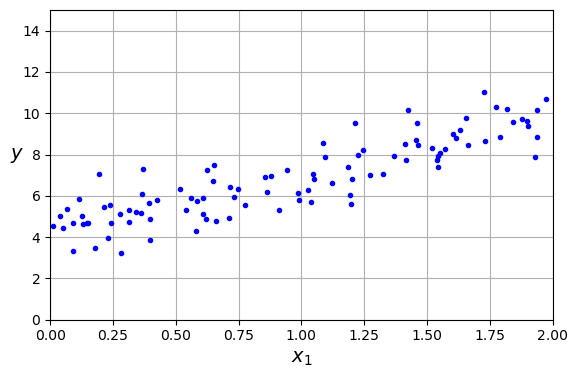

In [6]:
# extra code – generates and saves Figure 4–1

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("generated_data_plot")
plt.show()

现在让我们用标准方程来计算 $\hat{\pmb{\theta}}$ 。我们将使用从NumPy的线性代数模块（**np.linalg**）中得到的 **inv()** 函数来计算一个矩阵的逆，以及计算矩阵乘法的 **dot()** 方法：

In [7]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance

theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

我们用来生成数据的函数是 $y=4+3x_1 +高斯噪声$ 。让我们来看看这个等式的发现：

In [8]:
theta_best

array([[4.21509616],
       [2.77011339]])

我们本希望 $\theta_0=4$ 和 $\theta_1=3$ ，而不是 $\theta_0=4.215$ 和 $\theta_1=2.770$ 。虽然足够接近，但噪声使其无法恢复原始函数的精确参数。数据集越小、越嘈杂，就越难处理。

现在我们可以使用 $\hat{\pmb{\theta}}$ 进行预测：

In [9]:
X_new = np.array([[0], [2]])

X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance

y_predict = X_new_b @ theta_best

y_predict

array([[4.21509616],
       [9.75532293]])

让我们绘制模型的预测结果：

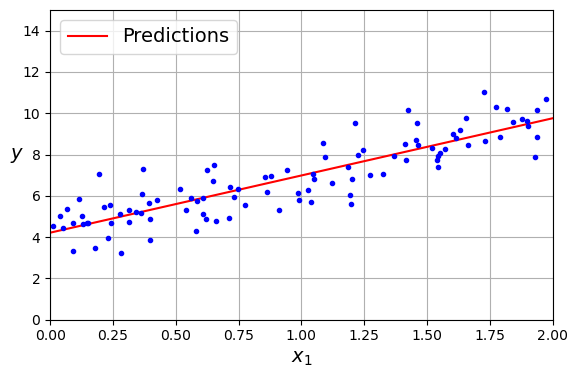

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
save_fig("linear_model_predictions_plot")

plt.show()

使用Scikit-Learn进行线性回归相对简单：

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [12]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

请注意，Scikit-Learn将偏差项（**intercept_**）与特征权重（**coef_**）分离开来。**LinearRegression** 类是基于 **scipy.linalg.lstsq()** 函数（名称代表“最小二乘”），您可以直接调用它：

In [13]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

theta_best_svd

array([[4.21509616],
       [2.77011339]])

该函数计算 $\hat{\pmb{\theta}}=\pmb{X}^+\pmb{y}$ ，其中 $\pmb{X}^+$ 是 $\pmb{X}$ 的伪逆（特别是，Moore–Penrose inverse）。您可以使用 **np.linalg.pinv()** 直接计算伪逆：

In [14]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

伪逆本身是使用一种称为 **奇异值分解（singular value decomposition，SVD）** 的标准矩阵分解技术来计算的，该技术可以将训练集矩阵 $X$ 分解为三个矩阵 $\pmb{U}\pmb{\Sigma}\pmb{V}^T$ 的矩阵乘法（见 **numpy.linalg.svd()** ）。

伪逆计算为 $\pmb{X}^+=\pmb{V}\pmb{\Sigma}^+\pmb{U}^T$ 。为了计算矩阵 $\Sigma^+$ ，算法取 $\pmb{\Sigma}$ 并将所有小于一个很小的阈值的值设为零，然后用它们的逆替换所有的非零值，最后对得到的矩阵进行转置。这种方法比计算正常方程更有效，加上它很好地处理边缘情况：事实上，如果矩阵 $\pmb{X}^T\pmb{X}$ 不可逆（即奇异），标准方程可能不工作。

### 1.2 计算复杂度（Computational Complexity）

标准方程计算 $\pmb{X}^T\pmb{X}$ 的逆，它是一个 $(n+1)\times(n+1)$ 的矩阵（其中 $n$ 是特征的数量）。这样一个矩阵求逆的计算复杂度通常是大约 $O(n^{2.4})$ 到 $O(n^3)$ ，这取决于实现。换句话说，如果你将特性的数量翻倍，那么你将计算时间乘以大约 $2^{2.4}=5.3$ 到 $2^3=8$ 。

Scikit-Learn的 **LinearRegression** 类所使用的 **SVD** 方法是大约 $O(n^2)$ 的。如果您将特征的数量翻倍，则您将计算时间大约乘以4。

此外，一旦你训练了你的线性回归模型（使用正常方程或任何其他算法），预测就会非常快：计算复杂度对于你想要进行预测的实例的数量和特征的数量都是线性的。换句话说，对两倍数量的实例（或两倍数量的特性）进行预测将花费大约两倍数量的时间。

现在，我们将研究一种非常不同的方法来训练线性回归模型，它更适合于有大量特征或太多的训练实例无法适应内存的情况

## 2. 梯度下降（Gradient Descent）

梯度下降是一种通用的优化算法，能够找到范围广泛的问题的最优解。梯度下降的一般思想是迭代地调整参数，以使代价函数最小化。

假设你在浓雾中，你只能感觉到脚下的斜坡。快速到达山谷底部的一个好策略是向最陡的斜坡的方向下坡。这正是梯度下降所做的：它度量关于参数向量 $\pmb{\theta}$ 的误差函数的局部梯度，并且它沿着梯度下降的方向前进。一旦梯度为零，你就达到了一个最小值！

在实践中，您首先用随机值填充 $\pmb{\theta}$（这称为随机初始化）。然后逐步改进，每次采取一个小步，每一步都试图降低成本函数（例如，MSE），直到算法收敛到最小值。

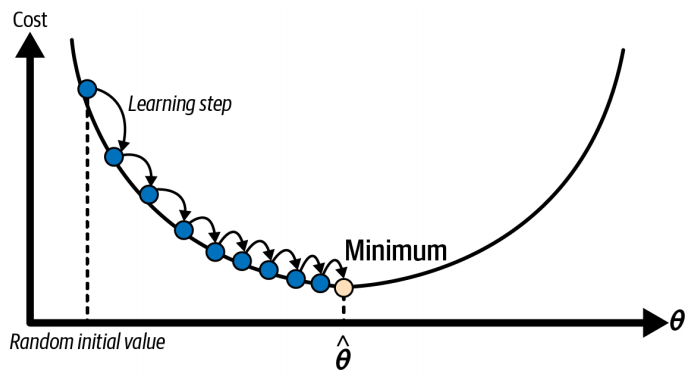

梯度下降中的一个重要参数是步长的大小，由 **学习率（learning rate）** 超参数决定。如果学习率太小，那么算法将需要经过多次迭代才能收敛，这将需要很长时间。

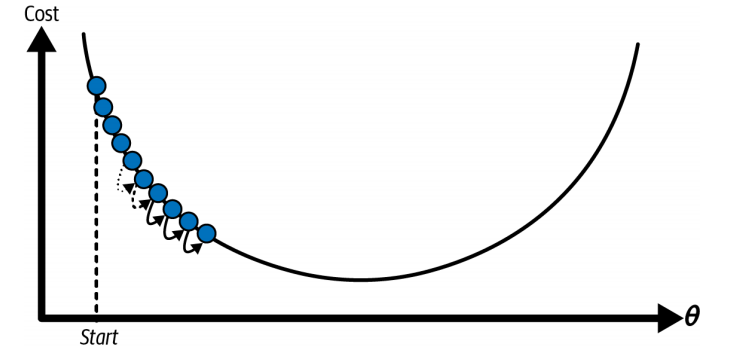

另一方面，如果学习率太高，你可能会跳过山谷，最终出现在另一边，甚至可能比以前更高。这可能会使算法发散，其值越来越大，无法找到一个好的解决方案。

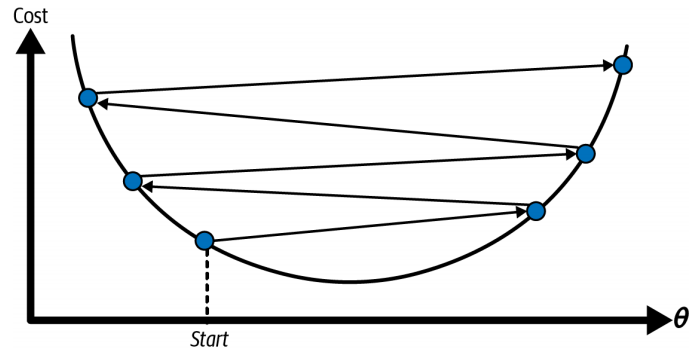

此外，并不是所有的成本功能看起来都像很漂亮的普通碗。可能会有洞、山脊、高原和各种不规则的地形，使收敛到最低限度的困难。

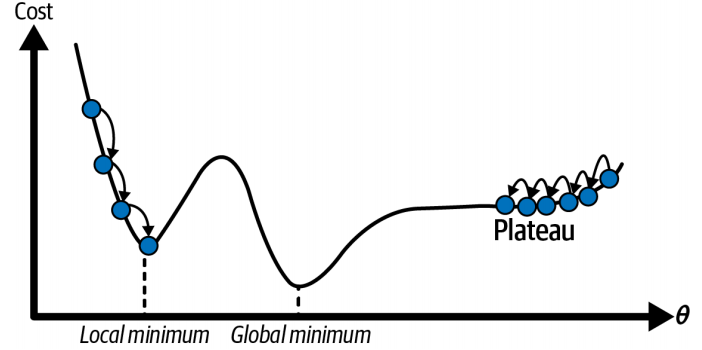

如图显示了在进行梯度下降时所面临的两个主要挑战。如果随机初始化在左边开始算法，那么它将收敛到一个局部最小值，这不如全局最小值好。如果它从右边开始，那么它将需要很长时间才能穿过高原。如果你过早停止，你将永远不会达到全球最低限度。

幸运的是，线性回归模型的 MSE 成本函数恰好是一个凸函数，这意味着如果你在曲线上选择任意两个点，连接它们的线段永远不会低于曲线之下。这意味着没有局部最小值，只有一个全局最小值。它也是一个连续函数，斜率不会突然变化。这两个事实有一个很大的结果：梯度下降保证任意接近全局最小值（如果你等待的时间足够长并且如果学习率不是太高）。

虽然成本函数有一个碗的形状，但如果特征有非常不同的尺度，它可以是一个拉长的碗。

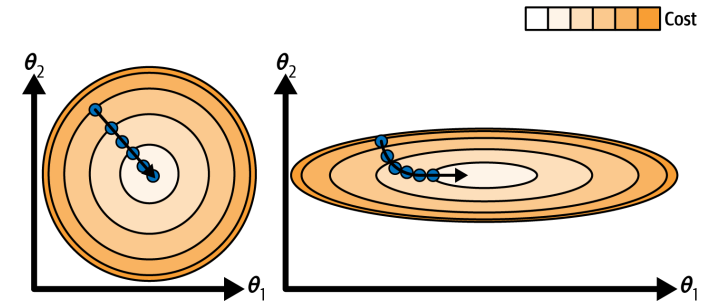

如图显示了在一个训练集上的梯度下降，其中特征1和特征2具有相同的尺度（在左边），而在一个训练集上，特征1的值比特征2要小得多（在右边）。

正如你所看到的，在左边梯度下降算法直接向最小，从而迅速到达，而在右边它第一个方向几乎正交的方向，它以一个几乎平坦的山谷。它最终会达到最低值，但这将需要很长时间。

**注意**：当使用梯度下降时，您应该确保所有特征都具有相似的比例（例如，使用Scikit-Learn的 **StandardScaler** 类），否则将需要更长的时间才能收敛。

该图还说明了这样一个事实，即训练一个模型意味着搜索一个模型参数的组合，使代价函数最小化（在训练集上）。它是在模型的参数空间中进行的搜索。模型拥有的参数越多，这个空间的维度就越多，搜索就越困难：在300维的干草堆中寻找针比在三维中要困难得多。幸运的是，由于成本函数在线性回归的情况下是凸的，所以针只是在碗的底部。

### 2.1 批量梯度下降（Batch Gradient Descent）

要实现梯度下降，您需要计算关于每个模型参数 $\theta_j$ 的成本函数的梯度。换句话说，如果你稍微改变一下 $\theta_j$ ，你需要计算成本函数会改变多少。这叫做偏导数。这就像是在问，“如果我朝东，我脚下的山坡是什么？”然后朝北问同样的问题（比如其他所有维度，如果你能想象一个具有三维以上维度的宇宙的话）。

**线性回归的MSE**：

$$ MSE(\pmb{X},h_{\pmb{\theta}})=\frac{1}{m}\sum_{i=1}^m(\pmb{\theta}^T\pmb{x}^{(i)}-y^{(i)})^2 $$

**计算MSE关于参数 $\theta_j$ 的偏导数**：

$$ \frac{\partial}{\partial\theta_j}MSE(\pmb{\theta})= \frac{2}{m}\sum_{i=1}^{m}(\pmb{\theta}^T\pmb{x}^{(i)}-y^{(i)})x_j^{(i)}$$

可以使用如下公式一次性计算它们，而不是单独计算这些偏导数。梯度向量，记作 $\bigtriangledown_{\pmb{\theta}}MSE(\pmb{\theta})$ ，包含代价函数的所有偏导数（每个模型参数一个）。

**成本函数的梯度向量**：

$$ \bigtriangledown_{\pmb{\theta}}MSE(\pmb{\theta})= 
\left(
\begin{matrix}
\frac{\partial}{\partial\theta_0}MSE(\pmb{\theta}) \\
\frac{\partial}{\partial\theta_1}MSE(\pmb{\theta}) \\
\vdots \\
\frac{\partial}{\partial\theta_n}MSE(\pmb{\theta})
\end{matrix}
\right)
=\frac{2}{m}\pmb{X}^T(\pmb{X}\pmb{\theta}-\pmb{y})
$$

**注意**：该公式涉及到在每个梯度下降步骤中对整个训练集 $\pmb{X}$ 的计算！这就是为什么该算法被称为批量梯度下降：它在每一步都使用整批训练数据（实际上，全梯度下降可能是一个更好的名字）。因此，它在非常大的训练集上非常慢（我们将很快看到一些更快的梯度下降算法）。然而，梯度下降规模随着特征的数量而增大；当有数十万个特征时，使用梯度下降训练线性回归模型比使用标准方程或SVD分解要快得多。

一旦你有了梯度向量，它指向上坡，只需朝相反的方向走下坡。这意味着从 $\pmb{\theta}$ 中减去 $\bigtriangledown_{\pmb{\theta}}MSE(\pmb{\theta})$ 。这就是学习速率 $\eta$ 发挥作用的地方：将梯度向量乘以 $\eta$ ，以确定下坡步长的大小。

**梯度下降步骤**：

$$ \pmb{\theta}^{(next\ step)}=\pmb{\theta}-\eta\bigtriangledown_{\pmb{\theta}}MSE(\pmb{\theta}) $$

让我们来看看这个算法的一个快速实现

In [15]:
eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)  # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

这并不难！在训练集上的每一次迭代都被称为一个历元。让我们来看看这个结果：

In [16]:
theta

array([[4.21509616],
       [2.77011339]])

这正是标准方程式得出的结果！梯度下降非常有效。但是如果你使用了不同的学习率（eta）呢？

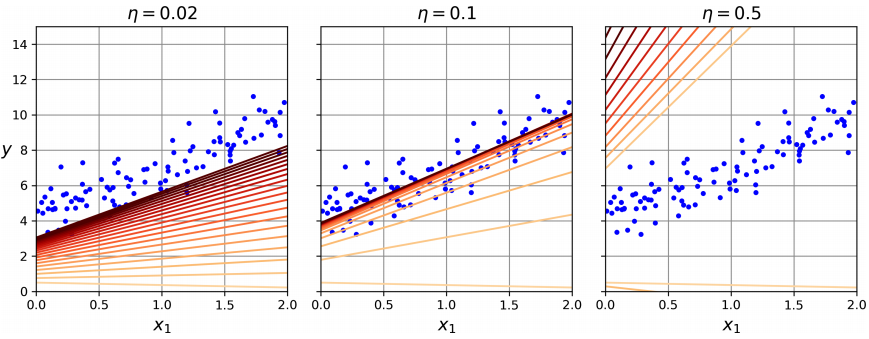

如图显示了使用三种不同学习速率的梯度下降的前20个步骤。每个图底部的线代表随机的起点，然后每个历元用一条较深和较深的线表示。

在左边，学习率太低：算法最终会解决，但需要很长时间。在中间，学习率看起来相当不错：在短短几个历元，它已经收敛到解决方案。在右边，学习率太高了：算法发散，每一步都越来越远。

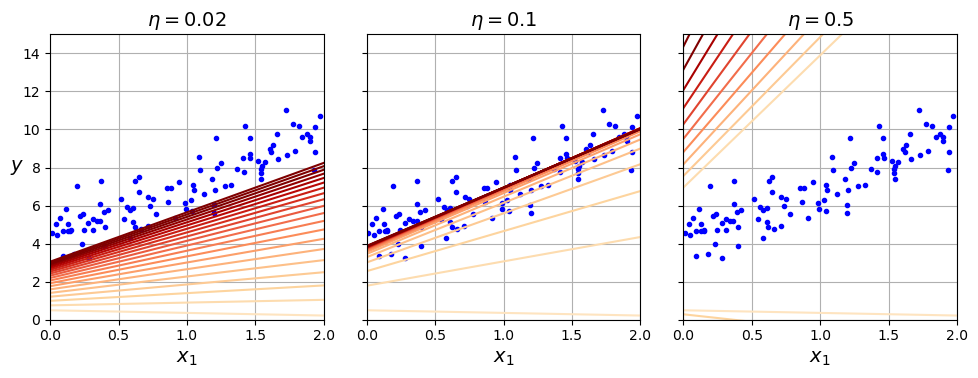

In [17]:
# extra code – generates and saves Figure 4–8

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
save_fig("gradient_descent_plot")
plt.show()

要找到良好的学习速度，您可以使用网格搜索。但是，您可能希望限制历元的数量，以便网格搜索可以去除需要太长时间才能收敛的模型。

你可能会想知道如何设置历元的数量。如果它过低，当算法停止时，你仍然会远离最优解；但如果它太高，您将浪费时间，而模型参数不再改变。一个简单的解决方案是设置大量的时期，但当梯度向量变得很小时中断算法——也就是说，当它的范数小于一个小数 $\epsilon$（称为公差）——因为此时梯度下降（几乎）达到最小值时。

### 2.2 随机梯度下降（Stochastic Gradient Descent）

批量梯度下降的主要问题是它使用整个训练集来计算每一步的梯度，这使得当训练集很大时，计算速度非常慢。在相反的极端，随机梯度下降在每一步在训练集中选择一个随机实例，并仅基于该单个实例计算梯度。显然，每次处理单个实例可以使算法速度快得多，因为它在每次迭代中需要操作的数据很少。它也使得在巨大的训练集上进行训练成为可能，因为每次迭代只需要一个实例在内存中（随机GD可以作为一个核外算法实现）。

另一方面，由于其随机性（即随机性）性质，该算法远不如批量梯度下降：代价函数不是缓慢下降直到达到最小值，而是上下反弹，只平均下降。随着时间的推移，它将会非常接近最小值，但一旦它到达那里，它就会继续反弹，永远不会安定下来。一旦算法停止，最终的参数值将是好的，但不是最优的。

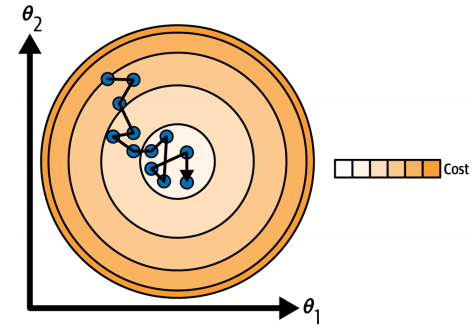

当代价函数非常不规则时，这实际上可以帮助算法跳出局部最小值，因此随机梯度下降比批量梯度下降有更好的机会找到全局最小值。

因此，随机性是逃避局部最优的好方法，但也不好，因为这意味着算法永远不能达到最小值。解决这个困境的一个方法是逐步降低学习率。这些步长一开始很大（这有助于快速取得进展并逃脱局部最小值），然后变得越来越小，允许算法达到全局最小值。这一过程类似于模拟退火，该算法的灵感来自于冶金退火过程，其中熔融金属被缓慢冷却。在每次迭代中决定学习速率的函数都被称为 **学习计划（learning schedule）** 。如果学习率降低得太快，您可能会陷入局部最小值，甚至最终冻结到最小值的一半。 如果学习率降低得太慢，你可能会在最小值附近跳跃很长时间，如果你过早停止训练，最终会得到一个次优的解决方案。

该代码使用一个简单的学习计划实现了随机梯度下降：

In [18]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure

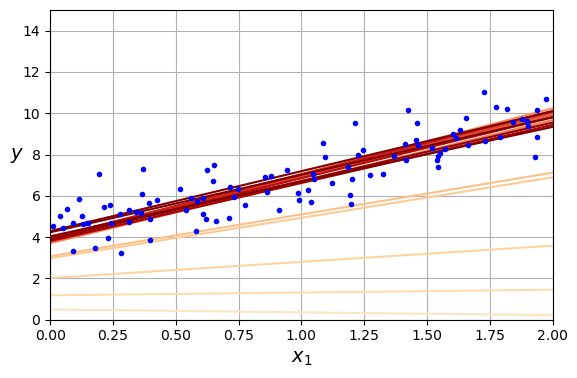

In [19]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("sgd_plot")
plt.show()

按照惯例，我们通过 $m$ 轮迭代；每一轮都被称为一个历元。批量梯度下降代码在整个训练集中迭代了1000次，但这个代码只在训练集中迭代了50次，得到了一个很好的解决方案：

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

请注意，由于实例是随机选择的，有些实例可能在每个时代选择几次，而其他实例可能根本不选择。如果您想确保算法在每个时代通过每个实例，另一种方法是洗牌训练集（确保共同洗牌输入特性和标签），然后一个实例地通过它，然后再次洗牌，以此类推。但是，这种方法比较复杂，而且通常不会改善结果。

**注意**：当使用随机梯度下降时，训练实例必须是 **独立同分布的（independent and identically distributed，IID）** ，以确保参数平均达到全局最优。确保这一点的一种简单方法是在训练期间打乱实例（例如，随机选择每个实例，或者在每个历元开始时打乱训练集）。如果不对实例进行洗牌——例如，如果实例按标签排序——那么SGD将首先优化一个标签，然后优化下一个标签，以此类推，它将不会接近全局最小值。

要使用Scikit-Learn的SGD执行线性回归，您可以使用 **SGDRegressor** 类，它默认为优化 MSE 成本函数。以下代码最多运行1000个周期（**max_iter**），或直到100个周期（**n_iter_no_change**）期间损失减少不到 $10^{-5}$（**tol**）。它从0.01（**eta0**）开始，使用默认的学习计划（与我们使用的不同）。最后，它不使用任何正则化（**penalty=None**）：

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5,
                       penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

再一次，你找到了一个非常接近标准方程返回的解：

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

**注意**：所有的 Scikit-Learn 估计器都可以使用 **fit()** 方法进行训练，但是有些估计器也有一个 **partial_fit()** 方法，您可以调用它在一个或多个实例上运行单轮训练（它忽略了像 **max_iter** 或 **tol** 这样的超参数）。反复调用 **partial_fit()** 将逐步训练模型。当您需要对培训过程进行更多的控制时，这一点很有用。其他模型则有一个 **warm_start** 超参数（有些两者都有）：如果你设置 **warm_start=True** ，在训练的模型上调用 **fit()** 方法不会重置模型；它只会在停止的地方继续训练，并受制于像 **max_iter** 和 **tol** 这样的超参数。注意，**fit()** 重置学习计划使用的迭代计数器，而 **partial_fit()** 不会。

### 2.3 小批量梯度下降（Mini-Batch Gradient Descent）

我们要看的最后一种梯度下降算法称为小批量梯度下降。一旦你了解了批量和随机梯度下降，它就很简单了：在每一步，小批量 GD 不是基于完整的训练集（如批量 GD）或仅基于一个实例（如随机 GD）计算梯度，而是在称为小批量的小随机实例集上计算梯度。小批量 GD 相对于随机 GD 的主要优势在于，您可以通过矩阵运算的硬件优化获得性能提升，尤其是在使用 GPU 时。

该算法在参数空间中的进展比随机 GD 稳定，尤其是对于相当大的小批量。 因此，小批量 GD 最终会比随机 GD 更接近最小值——但它可能更难逃离局部最小值。

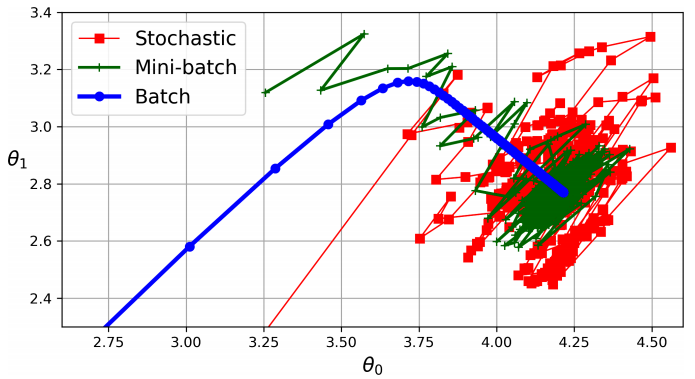

如图显示了三种梯度下降算法在训练过程中在参数空间中所走的路径。 它们都在最小值附近结束，但是批量 GD 的路径实际上停在了最小值处，而随机 GD 和小批量 GD 都在继续走来走去。 但是，不要忘记批量 GD 每一步都需要花费大量时间，如果使用良好的学习计划，随机 GD 和小批量 GD 也会达到最小值。

**线性回归算法的比较**：

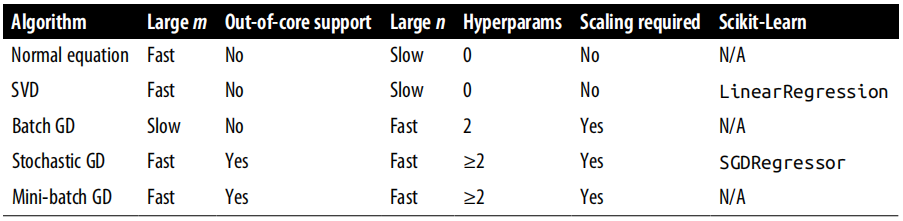

经过训练后，几乎没有任何区别：所有这些算法最终都有非常相似的模型，并以完全相同的方式进行预测。

## 3. 多项式回归（Polynomial Regression）

如果你的数据比一条直线更复杂呢？令人惊讶的是，您可以使用线性模型来拟合非线性数据。一个简单的方法是将每个特征的幂作为新特征添加进来，然后在这个扩展的特征集上训练一个线性模型。这种技术被称为多项式回归。

让我们来看一个例子。首先，我们将生成一些非线性数据，基于一个简单的二次方程，这是一个形为 $y=ax²+bx+c$ 的函数加上一些噪声：

In [23]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

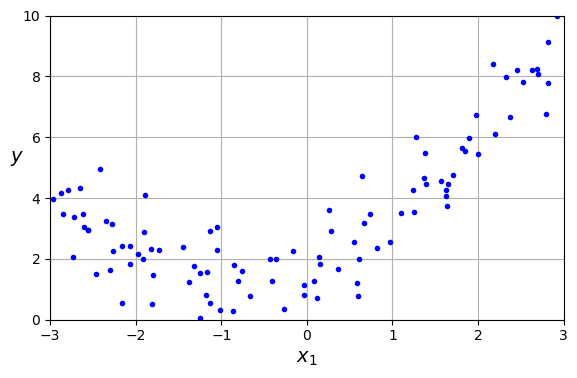

In [24]:
# extra code – this cell generates and saves Figure 4–12
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_data_plot")
plt.show()

显然，一条直线永远无法正确地匹配这个数据。所以，让我们使用Scikit-Learn的 **PolynomialFeatures** 类来转换我们的训练数据，添加训练集中每个特征的平方（次级多项式）作为一个新特征（在这种情况下只有一个特征）：

In [25]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

X[0]

array([-0.75275929])

In [26]:
X_poly[0]

array([-0.75275929,  0.56664654])

**X_poly** 现在包含了 **X** 的原始特性加上这个特性的平方。现在我们可以将一个线性回归模型拟合到这个扩展的训练数据中：

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

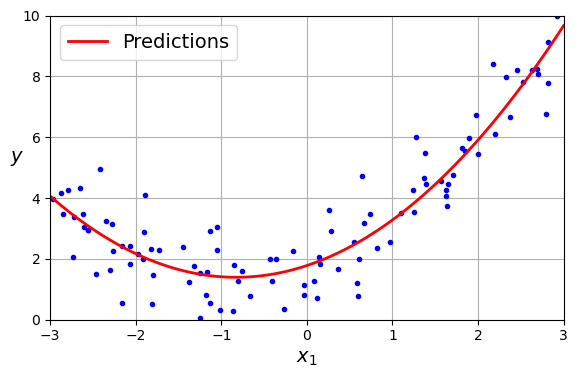

In [28]:
# extra code – this cell generates and saves Figure 4–13

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_predictions_plot")
plt.show()

不错。该模型估计了 $\hat{y} = 0.56x_1^2 + 0.93x_1 + 1.78$ ，而实际上原始函数是 $y = 0.5x_1^2 + 1.0x_1 + 2.0 +高斯噪声$ 。

请注意，当存在多个特征时，多项式回归能够找到特征之间的关系，而这是一个普通的线性回归模型所不能做到的。这是由于多项式特征也将所有特征的组合添加到给定的程度。例如，如果有两个特征 $a$ 和 $b$ ，那么 **degree=3** 的 **PolynomialFeatures** 不仅会添加特征 $a^2$ 、$a^3$ 、$b^2$ 和 $b^3$ ，还会添加组合 $ab$、$a^2b$ 和 $ab^2$ 。

**PolynomialFeatures(degree=d)** 将包含 $n$ 个特征的数组转换为包含 $\frac{(n+d)!}{d!n!}$ 个特征的数组。注意特征数量的组合爆炸！

## 4. 学习曲线（Learning Curves）

如果您执行高阶多项式回归，那么您很可能会比使用纯线性回归更好地拟合训练数据。

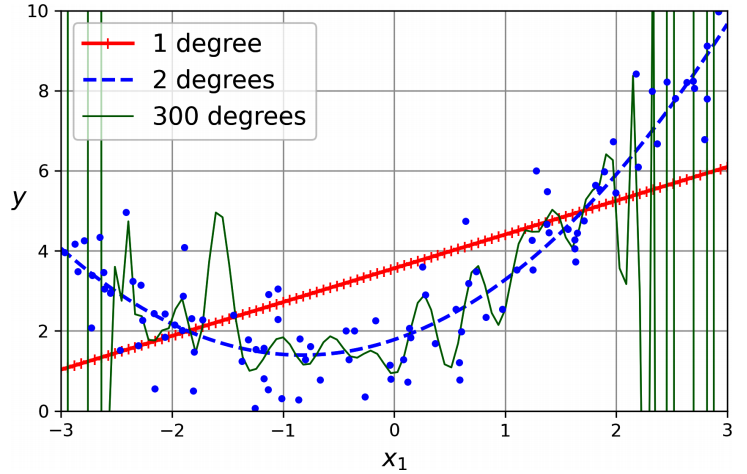

例如，上图将一个300阶多项式模型应用于前面的训练数据，并将其结果与一个纯线性模型和一个二次模型（二次多项式）进行了比较。请注意，300阶多项式模型是四处摆动，以尽可能地接近训练实例的。

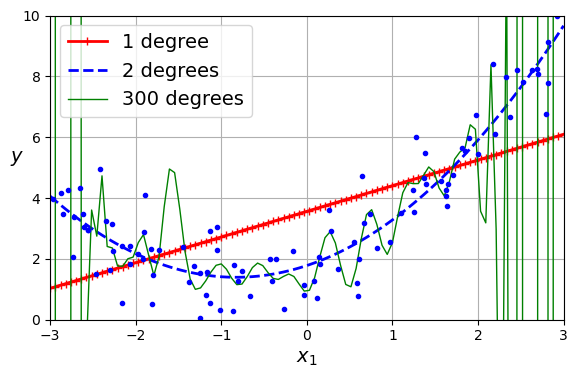

In [29]:
# extra code – this cell generates and saves Figure 4–14

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("high_degree_polynomials_plot")
plt.show()

这种高阶多项式回归模型对训练数据严重过拟合，而线性模型则拟合不足。在这种情况下，最能推广的模型是二次模型，这是有意义的，因为数据是使用二次模型生成的。但一般来说，您不知道是什么函数生成了数据，那么您如何决定模型应该有多复杂呢？你如何判断你的模型是过拟合或过拟合的数据？

在第 2 章中，您使用交叉验证来获得模型的泛化性能的估计值。如果一个模型在训练数据上表现良好，但根据交叉验证指标的泛化效果较差，那么你的模型就是过拟合的。如果它在两者上都表现不佳，那么它就拟合不足了。这是判断模型何时过于简单或过于复杂的一种方法。

另一种判断方法是查看 **学习曲线** ，它是模型的训练误差和验证误差随训练迭代变化的图：只需训练期间在训练集和验证集上定期评估模型，并绘制结果。如果无法增量训练模型（即，如果它不支持 **partial_fit()** 或 **warm_start**），则必须在训练集的逐渐变大的子集上多次训练它。

Scikit-Learn有一个有用的 **learning_curve()** 函数来帮助实现这一点：它使用交叉验证来训练和评估模型。默认情况下，它会对训练集的增长子集重新训练模型，但如果模型支持增量学习，您可以在调用 **learning_curve()** 时设置 **exploit_incremental_learning=True** ，它将增量训练模型。该函数返回它评估模型的训练集大小，以及它为每个大小和每个交叉验证折叠测量的训练和验证分数。让我们用这个函数来看看普通线性回归模型的学习曲线：

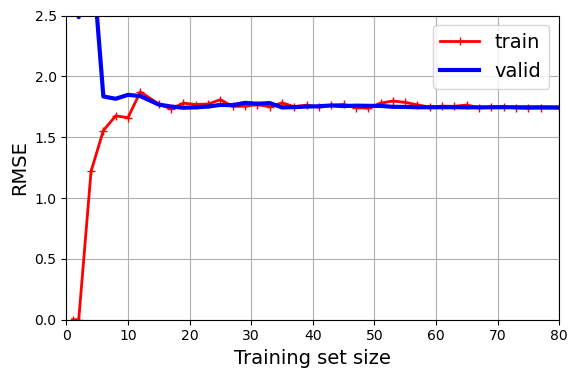

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5, scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
save_fig("underfitting_learning_curves_plot")

plt.show()

这个模型是拟合不足的。要了解原因，首先让我们看看训练误差。当训练集中只有一到两个实例时，模型可以完美地拟合它们，这就是为什么曲线从零开始。但是随着新的实例被添加到训练集中，模型不可能完美地拟合训练数据，既因为数据是有噪声的，也因为它根本不是线性的。因此，训练数据上的误差会上升，直到达到一个平台期，此时在训练集中添加新的实例并不会使平均误差更好或更糟。现在让我们来看看验证错误。当模型在很少的训练实例上进行训练时，它无法正确地进行推广，这就是为什么验证错误最初相当大的原因。然后，随着模型显示更多的训练示例，它学习，从而验证误差慢慢下降。然而，一条直线同样不能很好地对数据进行建模，所以误差最终达到一个平台，非常接近另一条曲线。

这些学习曲线是典型的欠拟合模型。两条曲线都达到了平台期；它们很近，而且相当高。

**注意**：如果你的模型欠拟合训练数据，添加更多的训练示例将没有帮助。您需要使用更好的模型或提供更好的特征。

现在让我们来看看一个10阶多项式模型在相同数据上的学习曲线：

In [31]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5, scoring="neg_root_mean_squared_error")

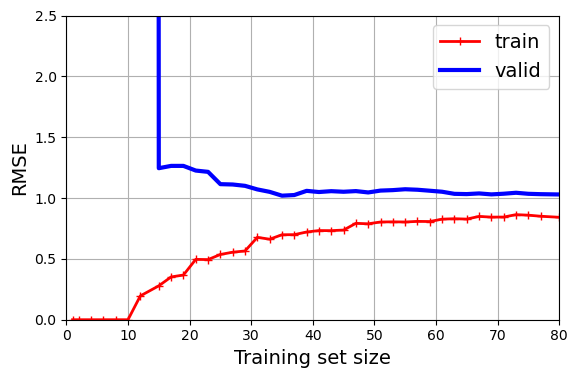

In [32]:
# extra code – generates and saves Figure 4–16

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
save_fig("learning_curves_plot")
plt.show()

**这些学习曲线看起来有点像以前的曲线，但有两个非常重要的区别**：

1. 训练数据上的误差比以前要小得多。
2. 曲线之间有间隙。 这意味着该模型在训练数据上的表现明显优于在验证数据上的表现，这是过拟合模型的标志。但是，如果使用更大的训练集，两条曲线将继续靠近。

**注意**：改进过拟合模型的一种方法是向其提供更多的训练数据，直到验证误差达到训练误差。

**偏差/方差权衡（The Bias/Variance Trade-Of）**：统计学和机器学习的一个重要理论结果是，一个模型的泛化误差可以表示为三个非常不同的误差的和：

- **偏差（Bias）**：这部分泛化误差是由于错误的假设造成的，比如假设数据是线性的而实际上是二次的。高偏差模型最有可能欠拟合训练数据。
- **方差（Variance）**：这部分泛化误差是由于模型对训练数据的微小变化过于敏感。具有许多自由度的模型（例如高阶多项式模型）可能具有高方差，从而过拟合训练数据。
- **不可约误差（Irreducible error）**：这部分泛化误差是由于数据本身的噪音。减少这部分错误的唯一方法是清理数据（例如，修复数据源，如损坏的传感器，或检测和删除离群值）。

增加一个模型的复杂性通常会增加它的方差并减少其偏差。相反，降低模型的复杂性会增加它的偏差，并减少它的方差。这就是为什么它被称为一种权衡。

## 5. 正则化线性模型（Regularized Linear Models）

正如您在第1章和第2章中所看到的，减少过拟合的一个好方法是将模型正则化（即约束它）：它的自由度越少，它就越难过拟合数据。正则化多项式模型的一种简单方法是减少多项式阶的数目。

对于一个线性模型，正则化通常是通过约束模型的权重来实现的。现在我们将研究 **岭回归（ridge regression）**、**套索回归（lasso regression）** 和 **弹性网络回归（elastic net regression）** ，它们实现了三种不同的方法来约束权重。

### 5.1 岭回归（Ridge Regression）

**岭回归（Ridge regression）** ，也称为 **提洪诺夫正则化（Tikhonov regularization）** ，是线性回归的一个正则化版本：一个等于 $\frac{\alpha}{m}\sum_{i=1}^n\theta_i^2$ 的正则化项被添加到MSE中。这迫使学习算法不仅拟合数据，而且还保持模型的权重尽可能小。请注意，正则项应该只在训练期间添加到成本函数中。一旦模型被训练好了，您就希望使用非正则化的MSE（或RMSE）来评估模型的性能。

超参数 $\alpha$ 控制了要正则化模型的程度。如果 $\alpha=0$ ，那么岭回归就是线性回归。如果 $\alpha$ 非常大，那么所有的权值都非常接近于零，结果是一条通过数据平均值的平线。

**岭回归成本函数**：

$$ J(\pmb{\theta})=MSE(\pmb{\theta})+\frac{\alpha}{m}\sum_{i=1}^{n}\theta_i^2 $$

注意，偏差项 $\theta_0$ 没有被正则化（和从 $i=1$ 开始，而不是0）。如果我们定义 $\pmb{w}$ 为特征权重的向量（ $\theta_1$ 到 $\theta_n$ ），则正则项等于 $\alpha(||\pmb{w}||_2)/m$ ，其中 $||\pmb{w}||_2$ 表示权值向量的 $ℓ2$ 范数。对于批量梯度下降，只需将 $\frac{2\alpha\pmb{w}}{m}$ 添加到对应于特征权值的 MSE 梯度向量的部分，而无需向偏差项的梯度添加任何东西。

**注意**：在执行岭回归之前，对数据进行缩放（例如，使用 **StandardScaler** ）是很重要的，因为它对输入特征的尺度很敏感。对于大多数正则化的模型都是如此。

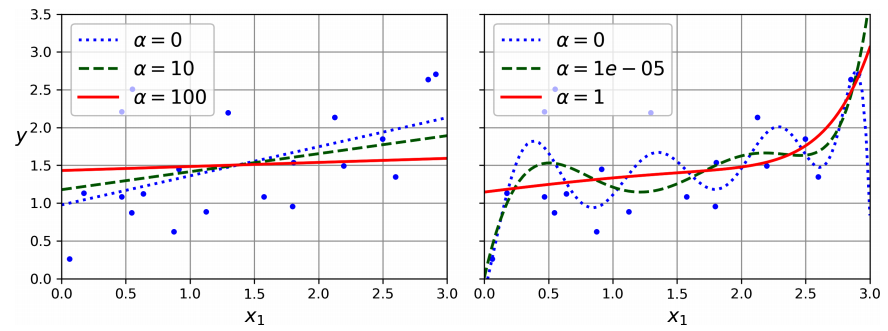

如图显示了几个岭模型，这些模型使用不同的 $\alpha$ 值在一些非常嘈杂的线性数据上进行训练。在左侧，使用了普通脊模型，导致线性预测。在右侧，数据首先使用 **PolynomialFeatures(degree=10)** 进行扩展，然后使用 **StandardScaler** 进行缩放，最后将岭模型应用于生成的特征：这是具有岭正则化的多项式回归。 请注意增加 $\alpha$ 导致更平坦（即不那么极端，更合理）的预测，从而减少模型的方差但增加其偏差。

与线性回归一样，我们可以通过计算一个封闭形式的方程或通过执行梯度下降来执行岭回归。利与弊是一样的。

**岭回归闭式解**：

$$ \hat{\pmb{\theta}}=(\pmb{X}^T\pmb{X}+\alpha \pmb{A})^{-1}\pmb{X}^T\pmb{y} $$

其中 $\pmb{A}$ 为 $(n+1)\times(n+1)$ 的单位矩阵，除了左上角单元格中有一个 0 ，对应于偏差项。

下面是用Scikit-Learn使用一个封闭形式的解进行岭回归（如上公式的一个变体，使用了安德烈-路易斯·乔莱斯基的矩阵分解技术）：

In [33]:
# extra code – we've done this type of generation several times before
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

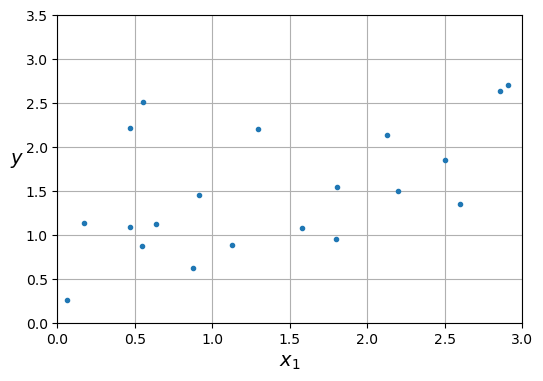

In [34]:
# extra code – a quick peek at the dataset we just generated
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [35]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

并使用随机梯度下降法：

In [36]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets

sgd_reg.predict([[1.5]])

array([1.55302613])

**penalty** 超参数设置了要使用的正则项的类型。指定“**l2**”表示希望 SGD 向 MSE 成本函数中添加一个正则项，它等于 **alpha** 乘以权重向量的 **ℓ2** 范数的平方。这就像岭回归，除了在这种情况下没有除以 **m** ；这就是为什么我们使用了 **alpha=0.1/m** ，以得到与 **Ridge(alpha=0.1)** 相同的结果。

**注意**：**RidgeCV** 类也执行岭回归，但它使用交叉验证自动调优超参数。它大致相当于使用 **GridSearchCV** ，但它对岭回归进行了优化，运行速度更快。其他一些估计器（主要是线性的）也有有效的CV变量，如 **LassoCV** 和 **ElasticNetCV** 。

### 5.2 套索回归（Lasso Regression）

**最小绝对收缩（Least absolute shrinkage）** 和 **选择算子回归（selection operator regression）**（通常简单地称为套索回归）是另一个正规化版本的线性回归：就像岭回归，它添加了一个正则项到成本函数，但它使用 $ℓ1$ 范数的权重向量而不是 $ℓ2$ 范式的平方。注意，$ℓ1$ 范数乘以 $2\alpha$ ，而 $ℓ2$ 范数在岭回归中乘以 $\frac{\alpha}{m}$ 。选择这些因素是为了确保最优的 $\alpha$ 值独立于训练集的大小：不同的范数导致不同的因素。

**套索回归成本函数**：

$$ J(\pmb{\theta})=MSE(\pmb{\theta})+2\alpha\sum_{i=1}^n|\theta_i| $$

**线性（左）和多项式（右）模型，都使用了不同层次的套索正则化**

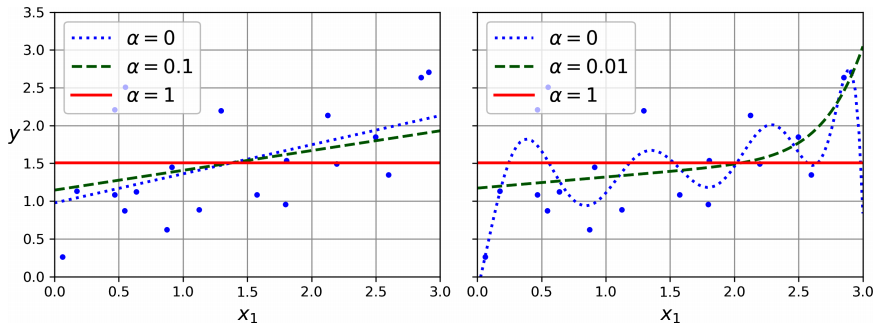

套索回归的一个重要特征是它倾向于消除最不重要特征的权重（即，将它们设置为零）。 例如，上图右侧图中的虚线（α = 0.01）看起来大致是立方：高阶多项式特征的所有权重都等于零。 换句话说，套索回归自动执行特征选择并输出具有很少非零特征权重的稀疏模型。

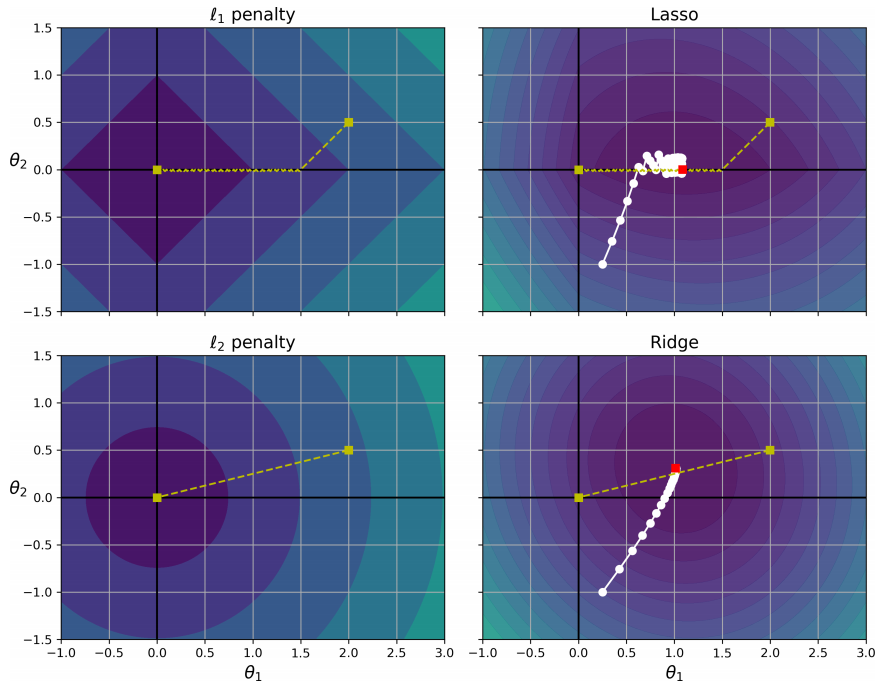

通过查看上图，您可以了解为什么会出现这种情况：轴代表两个模型参数，背景轮廓代表不同的损失函数。在左上角的图中，等高线表示 $ℓ1$ 损失 $|\theta_1|+|\theta_2|$ ，它随着您靠近任何轴而线性下降。 例如，如果您将模型参数初始化为 $\theta_1=2$ 和 $\theta_2=0.5$ ，则运行梯度下降会使两个参数均等地递减（如黄色虚线所示）； 因此 $\theta_2$ 将首先达到 0（因为它一开始就更接近0）。之后，梯度下降将沿着沟槽向下滚动，直到到达 $\theta_1=0$（有一点跳跃，因为 $ℓ1$ 的梯度永远不会接近 0：它们对于每个参数要么是–1要么是1）。在右上图中，等高线代表套索回归的成本函数（即 MSE 成本函数加上 $ℓ1$ 损失）。白色小圆圈显示梯度下降优化一些在 $\theta_1= 0.25$ 和 $\theta_2 =–1$ 附近初始化的模型参数的路径：再次注意路径如何快速到达 $\theta_2=0$ ，然后滚下沟槽并最终弹跳 围绕全局最优（由红色方块表示）。 如果我们增加 $\alpha$ ，全局最优值将沿着黄色虚线向左移动，而如果我们减小 $\alpha$ ，全局最优值将向右移动（在这个例子中，未正则化 MSE 的最优参数是 $\theta_1=2$ 和 $\theta_2=0.5$ ）。

底部的两个图显示了相同的东西，但却使用了 $ℓ2$ 惩罚。在左下角的图中，你可以看到随着我们接近原点，$ℓ2$ 损失减小，所以梯度下降只是直线下降。在右下角的图中，等高线表示岭回归的成本函数（即，一个MSE成本函数加上一个 $ℓ2$ 损失）。正如您所看到的，随着参数接近全局最优，梯度变小，因此梯度下降自然减慢。这限制了跳跃，这有助于岭回归比套索回归更快地收敛。还要注意，当你增加 $\alpha$ 时，最优参数（用红方块表示）越来越接近原点，但它们永远不会被完全消除。

**注意**：当使用套索回归时，为了防止梯度下降在最后的跳跃，你需要在训练过程中逐渐降低学习率。它仍然会在最优状态下反弹，但步长会越来越小，所以它会收敛。

套索成本函数在 $\theta_i=0\ (i=1,2,\cdots,n)$ 时不可微，但是如果当任何 $\theta_i=0$ 时使用次梯度向量 $\pmb{g}$ ，梯度下降仍然有效。

**套索回归次梯度向量**：

$$ g(\pmb{\theta},J)=\bigtriangledown_{\pmb{\theta}}+2\alpha
\left(
\begin{matrix}
sign(\theta_1) \\
sign(\theta_2) \\
\vdots \\
sign(\theta_n)
\end{matrix}
\right),\ where \ sign(\theta_i)=
\left\{
\begin{aligned}
-1,if\ \theta_i<0 \\
0,if\ \theta_i=0 \\
1,if\ \theta_i>0
\end{aligned}
\right.
$$

下面是一个小的 Scikit-Learn 使用 **Lasso** 类的例子：

In [37]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### 5.3 弹性网络回归（Elastic Net Regression）

弹性网回归是岭回归和套索回归之间的中间地带。正则项是岭和套索的正则项的加权和，你可以控制混合比 $r$ 。当 $r=0$ 时，弹性网络等同于岭回归，当 $r=1$ 时，它等同于套索回归。

**弹性网络回归成本函数**：

$$ J(\pmb{\theta})=MSE(\pmb{\theta})+r(2\alpha\sum_{i=1}^n|\theta_i|)+(1-r)(\frac{\alpha}{m}\sum_{i=1}^n\theta_i^2) $$

那么，什么时候应该使用弹性网络回归，或岭、套索，或普通线性回归（即，没有任何正则化）？至少有一点正则化几乎总是可取的，所以通常你应该避免纯线性回归。岭回归是一个很好的默认值，但如果你怀疑只有少数特征是有用的，你应该更喜欢套索回归或弹性网络回归，因为它们倾向于将无用的特征的权重减少到零，如前面所述。一般来说，弹性网络要比套索回归优先使用，因为当特征数量大于训练实例数量时或当多个特征强相关时，套索可能会表现不稳定。

这里是一个使用Scikit-Leain的 **ElasticNet**（**l1_ratio** 对应混合比率 **r** ）：

In [38]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 5.4 提前停止（Early Stopping）

一种非常不同的正则化迭代学习算法，如梯度下降的方法是在验证误差达到最小值时立即停止训练。这叫做提前停止。

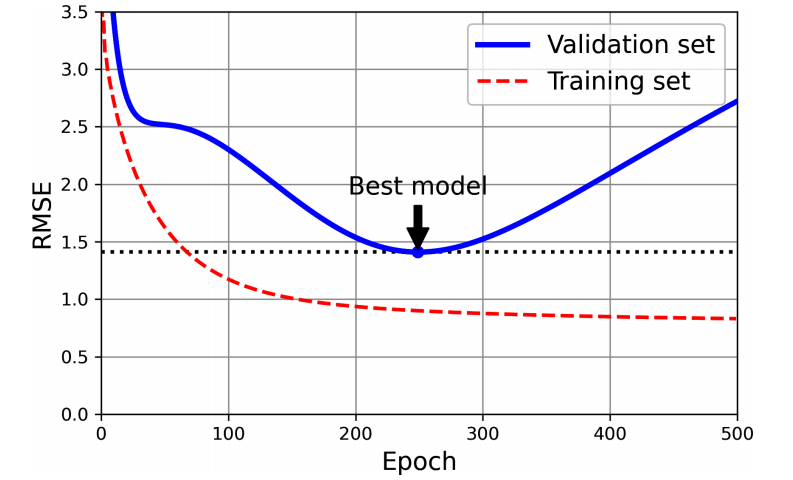

如图显示了一个复杂的模型（在这种情况下，是一个高度多项式回归模型），在我们之前使用的二次数据集上使用批量梯度下降进行训练。随着时代的流逝，算法不断学习，其在训练集上的预测误差（RMSE）不断下降，其在验证集上的预测误差也不断下降。但是，一段时间后，验证错误将停止递减，并开始回升。这表明该模型已经开始过拟合训练数据。通过早期停止，您只要在验证错误达到最小值时就会停止训练。这是一种如此简单和有效的正则化技术，杰弗里·辛顿称之为“美丽的免费午餐”。

**注意**：通过随机的和小批量的梯度下降，曲线就不那么平滑了，而且可能很难知道你是否已经达到了最小值。一种解决方案是，只有在验证错误超过最小值一段时间后（当您确信模型不会做得更好时）才停止，然后将模型参数回滚到验证错误最小的点。

以下是一个提前停止的基本实现：

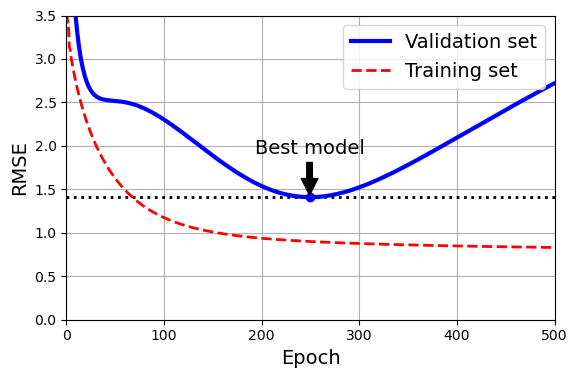

In [39]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates and saves Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
save_fig("early_stopping_plot")
plt.show()

该代码首先添加多项式特征，并标准化所有的输入特征，包括训练集和验证集（代码假设您已经将原始训练集分割成一个更小的训练集和一个验证集）。然后创建一个没有正则化且学习率小的 **SGDRegressor** 模型。在训练循环中，它调用 **partial_fit()** 而不是 **fit()** 来执行增量学习。在每个历元，它度量验证集上的RMSE。如果它低于迄今为止所见的最低RMSE，它将在 **best_model** 变量中保存一个模型的副本。这个实现实际上并没有停止训练，但它可以让您在训练后恢复到最佳模型。请注意，模型是使用 **copy.deepcopy()** 复制的，因为它复制模型的超参数和学习的参数。相比之下，**sklearn.base.clone()** 只复制了模型的超参数。

## 6. 逻辑回归（Logistic Regression）

如在第1章中所讨论的，一些回归算法可以用于分类（反之亦然）。逻辑回归通常用来估计一个实例属于一个特定类的概率（例如，该电子邮件是垃圾邮件的概率是多少？）。如果估计的概率大于一个给定的阈值（通常是50%），那么模型预测该实例属于该类（称为正类，标记为“1”），否则它预测它不属于（即，它属于负类，标记为“0”）。这使得它成为了一个二值分类器。

### 6.1 估计概率（Estimating Probabilities）

那么逻辑回归是如何工作的呢？与线性回归模型一样，逻辑回归模型计算输入特征的加权和（加上一个偏差项），但它不像线性回归模型那样直接输出结果，而是输出这个结果的逻辑。

**逻辑回归模型估计概率（向量化形式）**：

$$ \hat{p}=h_{\pmb{\theta}}(\pmb{x})=\sigma(\pmb{\theta}^T\pmb{x}) $$

逻辑回归记为 $\sigma(\cdot)$ 是一个 sigmoid 函数（即S形），它输出一个介于0到1之间的数字。

**逻辑函数**：

$$ \sigma(t)=\frac{1}{1+exp(-t)} $$

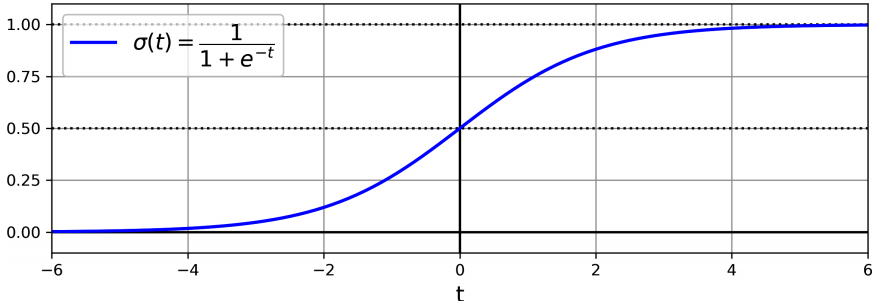

一旦逻辑回归模型估计了一个实例 $\pmb{x}$ 属于正类的概率 $\hat{p}=h_{\theta}(\pmb{x})$ ，它就可以很容易地进行预测 $\pmb{y}$ 。

**使用50%的阈值概率的逻辑回归模型预测**：

$$\hat{y}=
\left\{
\begin{aligned}
0,if\ \hat{p}<0.5 \\
1,if\ \hat{p}\ge0.5 
\end{aligned}
\right.
$$

注意，$t<0$ 时 $\sigma(t)<0.5$ ，$t\ge0$ 时 $\sigma(t)\ge0.5$ ，因此使用 50% 概率默认阈值的逻辑回归模型预测的是，如果 $\pmb{\theta}^T\pmb{x}$ 为正则为1，如果为负则为0。

**注意**：分数 $t$ 通常被称为 logit 。这个名称来自于 logit 函数，定义为 $logit(p)=log(\frac{p}{(1-p)})$ ，是逻辑函数的逆函数。事实上，如果你计算估计概率 $p$ 的 logit ，你会发现结果是 $t$ 。logit 也被称为对数概率，因为它是正类的估计概率和负类的估计概率之比的对数。

### 6.2 训练和成本函数（Training and Cost Function）

现在你知道了一个逻辑回归模型是如何估计概率并做出预测的。但是它是如何被训练的呢？训练的目的是设置参数向量 $\pmb{\theta}$ ，使模型为正实例估计高概率（ $y=1$ ）并为负实例估计低概率（ $y=0$ ）。

**单个训练实例的成本函数**：

$$ c(\pmb{\theta})=
\left\{
\begin{aligned}
-log(\hat{p}),if\ y=1 \\
-log(1-\hat{p}),if\ y=0
\end{aligned}
\right.
$$

这个成本函数是有意义的，因为当 $t$ 接近0时，$-log(t)$ 变得非常大，所以如果模型估计一个正实例的概率接近0，成本就会很大，如果模型估计一个负实例的概率接近1，那么成本也会很大。另一方面，当 $t$ 接近于1时，-log(t)接近于0，所以如果估计的概率对于负实例的概率接近于0，或者对于正实例接近于1，那么成本将接近于0，这正是我们想要的。

整个训练集的成本函数是所有训练实例的平均代价。它可以写成一个称为 **对数损失（log loss）** 的单一表达式。

**逻辑回归成本函数（对数损失）**：

$$ J(\pmb{\theta})=-\frac{1}{m}\sum_{i=1}^m[y^{(i)}log(\hat{p})^{(i)}+(1-y^{(i)})log(1-\hat{p}^{(i)})] $$

**注意**：对数损失并不是凭空提出的。它可以从数学上证明（使用贝叶斯推理），最小化这个损失将导致模型具有最大的最优可能性，假设实例遵循其类平均值周围的高斯分布。当您使用对数丢失时，这是您所做的隐含假设。这个假设越错误，模型的偏差就越大。类似地，当我们使用MSE来训练线性回归模型时，我们很明确地假设数据是纯线性的，再加上一些高斯噪声。因此，如果数据不是线性的（例如，如果它是二次分布的），或者如果噪声不是高斯分布的（例如，如果异常值不是指数罕见的），那么模型将是有偏的。

坏消息是，没有已知的封闭形式的方程来计算 $\pmb{\theta}$ 的值来最小化这个成本函数（没有标准方程的等价物）。但好消息是，这个代价函数是凸的，所以梯度下降（或任何其他优化算法）都可以保证找到全局最小值（如果学习率不是太大，而且你等待的时间足够长）。

**逻辑成本函数的偏导数**：

$$\frac{\partial}{\partial\theta_j}J(\pmb{\theta})=\frac{1}{m}\sum_{i=1}^m(\sigma(\pmb{\theta}^T\pmb{x}^{(i)})-y^{(i)})x_j^{(i)}$$

对于每个实例，它计算预测误差，并将其乘以第 $j$ 个特征值，然后它计算所有训练实例的平均值。一旦您有了包含所有偏导数的梯度向量，您就可以在批处理梯度下降算法中使用它。就是这样：你现在知道如何训练一个逻辑回归模型了。对于SGD，您将一次取一个实例，而对于小批量GD，您将一次使用一个小批量。

### 6.3 决策边界（Decision Boundaries）

我们可以使用 **鸢尾属数据集（iris dataset）** 来说明逻辑回归。这是一个著名的数据集，它包含了三种不同物种的150朵鸢尾属花的萼片和花瓣的长度和宽度：setosa 鸢尾属、versicolor 鸢尾属和 virginica 鸢尾属。

让我们尝试构建一个分类器，仅基于花瓣宽度特征来检测 Iris virginica 类型。 第一步是加载数据并快速浏览一下：

In [40]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [42]:
print(iris.DESCR)  # extra code – it's a bit too long

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [43]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [45]:
iris.target.head(3)  # note that the instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int32

In [46]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

接下来，我们将分割数据，并在训练集上训练一个逻辑回归模型：

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

让我们来看看模型中花瓣宽度从0厘米到3厘米不等的花的估计概率：

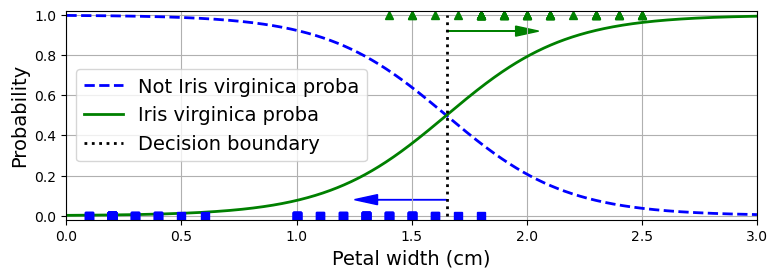

In [52]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies and saves Figure 4–23
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
save_fig("logistic_regression_plot")

plt.show()

鸢尾花（用三角形表示）的花瓣宽度在 1.4 厘米到 2.5 厘米之间，而其他鸢尾花（用正方形表示）的花瓣宽度一般较小，在 0.1 厘米到 1.8 厘米之间。 请注意，有一点重叠。 在大约 2 cm 以上，分类器高度确信这朵花是 Iris virginica，而在 1 cm 以下，它高度确信它不是 Iris virginica。在这两个极端之间，分类器是不确定的。但是，如果您要求它预测类别（使用 predict() 方法而不是 predict_proba() 方法），它将返回最有可能的类别。 因此，在 1.6 厘米左右有一个决策边界，两个概率都等于 50% ：如果花瓣宽度大于 1.6 厘米，分类器将预测这朵花是 Iris virginica，否则它将预测它不是 （虽然不是很自信）：

In [53]:
decision_boundary

1.6516516516516517

In [54]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

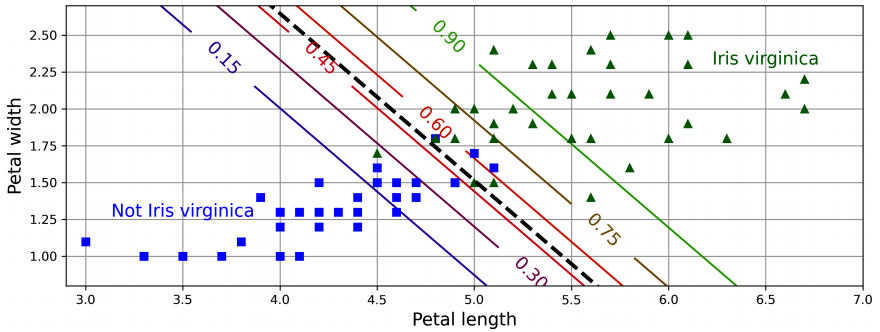

如图显示了相同的数据集，但这次显示了两个特征：花瓣的宽度和长度。一旦训练好，逻辑回归分类器就可以根据这两个特征，估计一朵新花是 Iris virginica 的概率。虚线表示模型估计 50% 概率的点：这是模型的决策边界。请注意，它是一个线性边界。每条平行线代表模型输出特定概率的点，从15%（左下角）到90%（右上角）。根据该模型，右上方线以外的所有花都有超过90%的几率是 Iris virginica 。

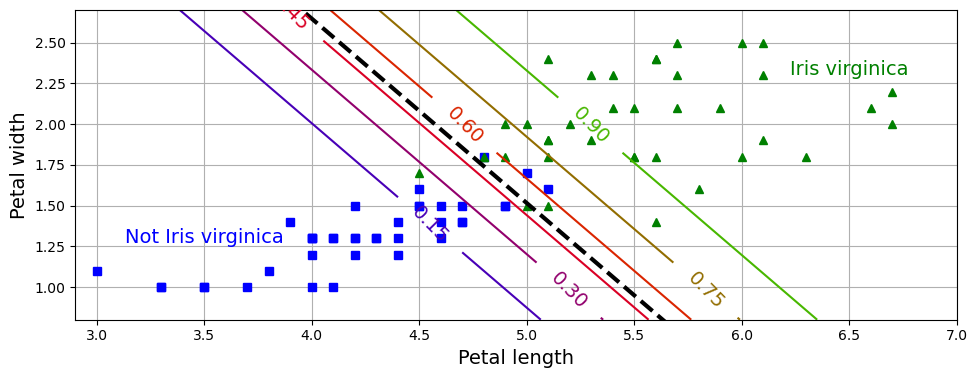

In [61]:
# extra code – this cell generates and saves Figure 4–24

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
save_fig("logistic_regression_contour_plot")
plt.show()

**注意**：控制 Scikit-Learn **LogisticRegression** 模型正则化强度的超参数不是 **alpha**（像其他线性模型）那样，而是它的倒数：**C** 。**C** 的值越高，模型的正则化就越弱。

与其他线性模型一样，逻辑回归模型也可以使用 $ℓ1$ 或 $ℓ2$ 惩罚进行正则化。Scikit-Learn 实际上在默认情况下添加了一个 $ℓ2$ 惩罚。

### 6.4 Softmax 回归（Softmax Regression）

逻辑回归模型可以推广到直接支持多个类，而不需要训练和组合多个二进制分类器（如第3章所述）。这被称为 **softmax 回归（softmax regression）** ，或 **多项式逻辑回归（multinomial logistic regression）** 。

这个想法很简单：当给定一个实例 $\pmb{x}$ 时，softmax 回归模型首先为每个类 $k$ 计算一个分数 $s_k(\pmb{x})$ ，然后通过对分数应用 softmax 函数（也称为 **归一化指数（normalized exponential）** ）来估计每个类的概率。计算 $s_k(\pmb{x})$ 的方程应该看起来很熟悉，因为它正好类似于线性回归预测的方程。

**类别 k 的 softmax 得分**：

$$ s_k(\pmb{x})=(\pmb{\theta}^{(k)})^T\pmb{x} $$

注意，每个类都有自己的专用参数向量 $\pmb{\theta}^{(k)}$ 。所有这些向量通常都以行的形式存储在一个参数矩阵 $\pmb{\Theta}$ 中。

一旦您计算了实例 $\pmb{x}$ 的每个类的分数，您就可以通过 softmax 函数运行计算分数来估计实例属于类 $k$ 的概率 $\hat{p}_k$ 。该函数计算每个分数的指数，然后将它们归一化（除以所有指数的和）。这些分数通常被称为 **logits** 或 **log-odds**（尽管它们实际上是未正则化的对数概率）。

**softmax 函数**：

$$ \hat{p}_k=\sigma(\pmb{s}(\pmb{x}))_k=\frac{exp(s_k(\pmb{x}))}{\sum_{j=1}^K exp(s_j(\pmb{x}))} $$

方程中：
- $K$ 是类的数目
- $\pmb{s}(\pmb{x})$ 是实例 $\pmb{x}$ 关于每个类的得分向量
- $\sigma(\pmb{s}(\pmb{x}))_k$ 是实例 $\pmb{x}$ 属于类 $k$ 的估计概率

与逻辑回归分类器一样，默认情况下，softmax 回归分类器预测估计概率最高的类（即得分最高的类）。

**softmax 回归分类器预测**：

$$ \hat{y}=\arg \max_k \sigma(\pmb{s}(\pmb{x}))_k=\arg \max_{k} s_k(\pmb{x})=\arg\max_k((\pmb{\theta}^{(k)})^T\pmb{x}) $$

**argmax** 运算符返回一个使函数最大化的变量的值。在这个方程中，它返回 $k$ 的值，使估计的概率 $\sigma(\pmb{s}(\pmb{x}))_k$ 最大化。

**注意**：softmax 回归分类器一次只预测一个类（即，它是多类的，而不是多输出的），所以它应该只用于互斥的类，如不同种类的植物。你不能用它在一张图片中识别多个人。

现在您知道模型如何估计概率并做出预测，让我们来看看训练。目标是拥有一个模型来估计目标类的高概率（因此其他类的概率很低）。 

**交叉熵成本函数**：

$$ J(\pmb{\Theta})=-\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K y_k^{(i)}log(\hat{p}_K^{(i)}) $$

在这个方程中，$y_k^{(i)}$ 是第 $i$ 个实例属于 $k$ 类的目标概率。通常，它要么等于 1 或 0 ，这取决于实例是否属于该类。请注意，当只有两个类（$K=2$）时，该成本函数等同于逻辑回归成本函数（对数损失)。

最小化公式中所示的成本函数（称为交叉熵）应该可以实现此目标，因为它会在模型估计目标类别的概率较低时惩罚模型。 交叉熵经常用于衡量一组估计的类别概率与目标类别的匹配程度。

**交叉熵（Cross Entropy）**：交叉熵起源于 克劳德·香农 的信息论。假设您想每天高效地传输有关天气的信息。如果有八个选项（晴天、雨天等），您可以使用 3 位对每个选项进行编码，因为 $2^3=8$ 。但是，如果您认为几乎每天都是晴天，那么编码“ sunny”仅在一位 (0) 上显示，其他七个选项在四位上显示（从 1 开始）。交叉熵测量每个选项实际发送的平均位数。如果您对天气的假设是完美的，则交叉熵将等于天气本身的熵（即其内在的不可预测性）。但是，如果您的假设是错误的（例如，如果经常下雨），交叉熵将增大一个称为 Kullback–Leibler (KL) 散度的量。两个概率分布 $p$ 和 $q$ 之间的交叉熵被定义为 $H(p,q)=-\sum_x p(x)logq(x)$（至少当这些分布是离散的时）。

**第 $k$ 类的交叉熵梯度向量**：

$$ \bigtriangledown_{\pmb{\theta}}^{(k)}J(\pmb{\Theta})=\frac{1}{m}\sum_{i=1}^m (\hat{p}_k^{(i)}-y_k^{(i)})\pmb{x}^{(i)}$$

现在您可以计算每个类的梯度向量，然后使用梯度下降（或任何其他优化算法）来找到使代价函数最小化的参数矩阵 $\pmb{\Theta}$ 。

让我们使用 softmax 回归将鸢尾花分为三类。当你在两个以上的类上进行训练时，逻辑回归分类器会自动使用 softmax 回归（假设你使用 **solver="lbfgs"** ，这是默认的）。它还在默认情况下应用 $ℓ2$ 正则化，您可以使用超参数 $C$ 来控制，如前所述：

In [62]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)

softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

所以，下次你发现一个花瓣5厘米长，2厘米宽的鸢尾花时，你可以让你的模型告诉你它是什么类型的鸢尾花，它会以 96% 的概率回答 Iris virginica（2类）（或 4% 的 Iris versicolor ）：

In [63]:
softmax_reg.predict([[5, 2]])

array([2])

In [64]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

如图显示了生成的决策边界，由背景颜色表示。请注意，任何两个类之间的决策边界都是线性的。图中还显示了 Iris versicolor 类的概率，由曲线（例如，标记为0.30的线表示30%的概率有界）展示。请注意，该模型可以预测一个估计概率低于 50% 的类。例如，在所有决策边界相遇的点上，所有类的估计概率都相等，为33%。

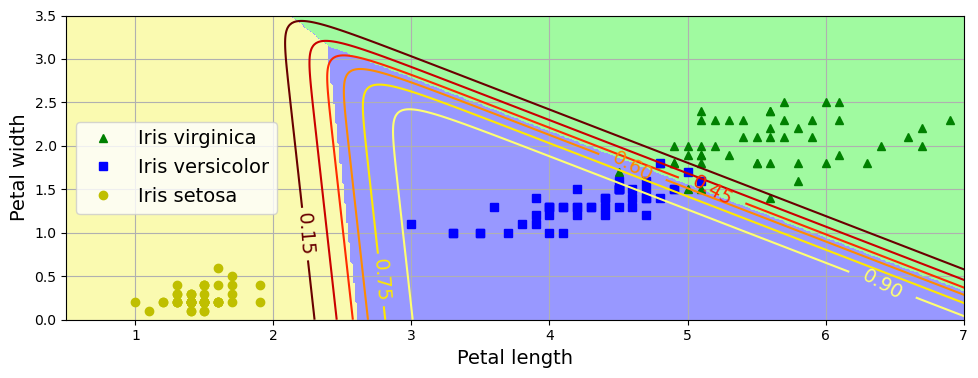

In [65]:
# extra code – this cell generates and saves Figure 4–25

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("softmax_regression_contour_plot")
plt.show()

在本章中，您学习了训练线性模型的各种方法，包括用于回归和分类。您使用了一个封闭形式的方程来解决线性回归，以及梯度下降，并了解了如何在训练期间向成本函数中添加各种惩罚来规范模型。在此过程中，您还学习了如何绘制学习曲线并分析它们，以及如何实现早期停止。最后，您了解了逻辑回归和软最大回归是如何工作的。我们已经打开了第一台机器学习的黑匣子！在下一章中，我们将打开更多的内容，从支持向量机开始。